## Setup

In [1]:
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch import nn, optim
from torch.utils.data import TensorDataset
from torcheval.metrics import functional as funcmetrics
from ucimlrepo import fetch_ucirepo

from common import *

In [2]:
torch.manual_seed(2024)
torch.use_deterministic_algorithms(True)

In [3]:
data = pd.read_csv('datasets/firewall.csv')

X = data.drop('Action', axis=1)
y = data['Action']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,177,94,83,2,30,1,1
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,314,192,122,6,15,4,2
65528,50964,80,13485,80,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,70,70,0,1,0,1,0
65530,54870,445,0,0,70,70,0,1,0,1,0


In [4]:
firewall_scaler = StandardScaler()
firewall_dataset = TensorDataset(
    torch.tensor(firewall_scaler.fit_transform(X), dtype=torch.float),
    torch.tensor(y).flatten()
)

firewall_datasets = shuffle_train_valid_test_split(firewall_dataset)
firewall_headers: list = X.keys().to_list()

In [5]:
def optimizer_factory(model):
    return optim.Adam(model.parameters(), lr=0.001)


criterion = nn.CrossEntropyLoss()

In [6]:
labels = ("accuracy", "f1-score")


def score_outputs(outputs, targets):
    return (
        funcmetrics.multiclass_accuracy(
            outputs, targets, average='macro', num_classes=4).item(),
        funcmetrics.multiclass_f1_score(
            outputs, targets, average='macro', num_classes=4).item(),
    )

## Base model

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim=11, hidden_dims=(4, 4), output_dim=4):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )
        self.out = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x)
        return x

/home/szynka/Projects/Studia/xai/.venv/lib64/python3.12/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:232.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


test: ('accuracy', 'f1-score'): (0.7445205450057983, 0.7433592081069946)


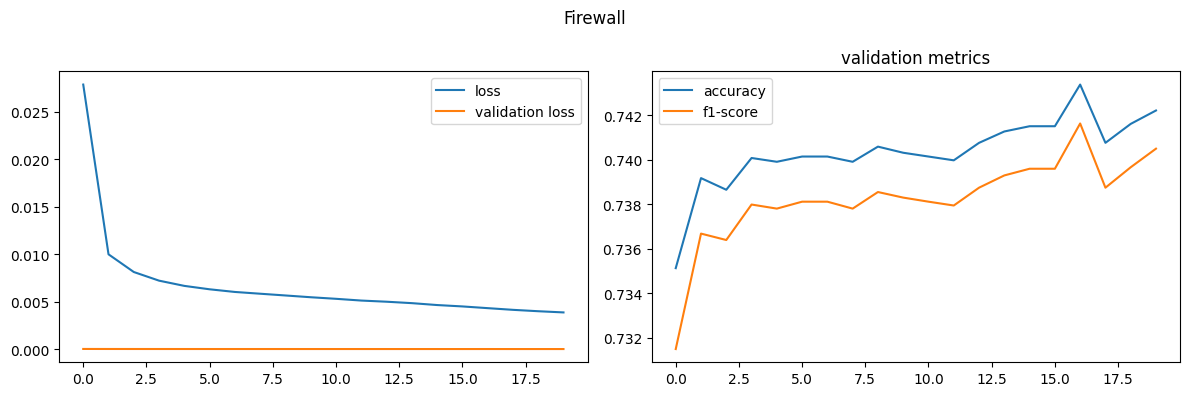

In [8]:
datasets = firewall_datasets

model = MLP()
optimizer = optimizer_factory(model)

metrics = model_train(datasets, model, optimizer, criterion, score_outputs, 20)

with torch.no_grad():
    inputs, targets = datasets["test"][:]
    outputs = model(inputs)

    test_metrics = score_outputs(outputs, targets)

print(f"test: {labels}: {test_metrics}")
plot_metrics('Firewall', metrics, labels)

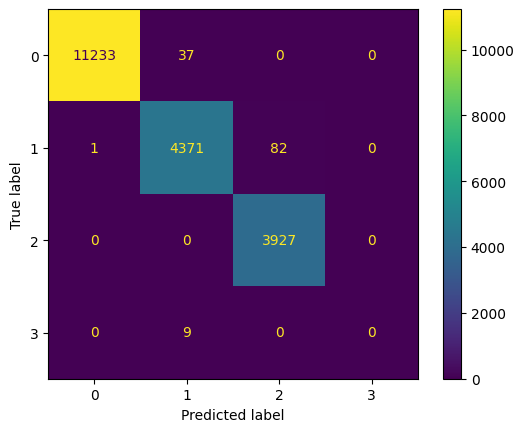

In [9]:
ConfusionMatrixDisplay.from_predictions(targets, outputs.argmax(dim=1))
plt.show()

## DGSM

In [10]:
best_model = MLP()

### input layer

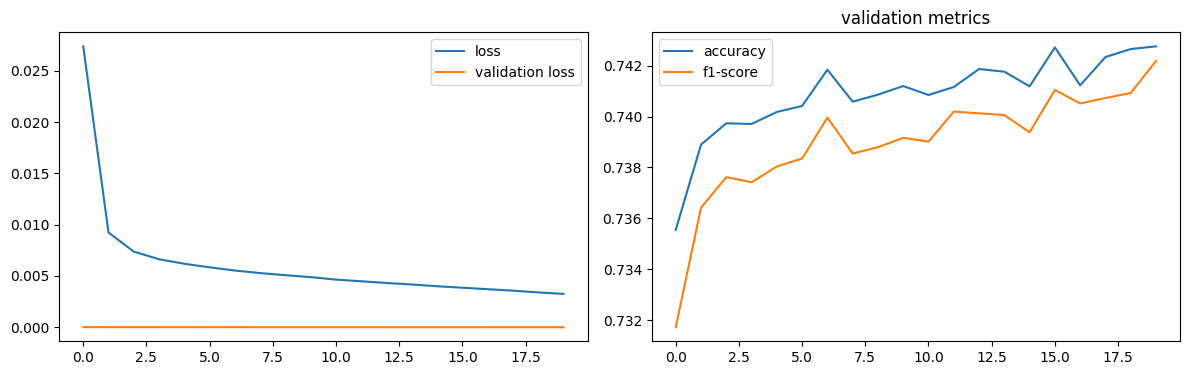

num of dropped: 0
Test: loss: 0.019204678013920784, avg metrics: (0.7441701650619507, 0.7431782841682434)
dropping feature: (0, 'Source Port')


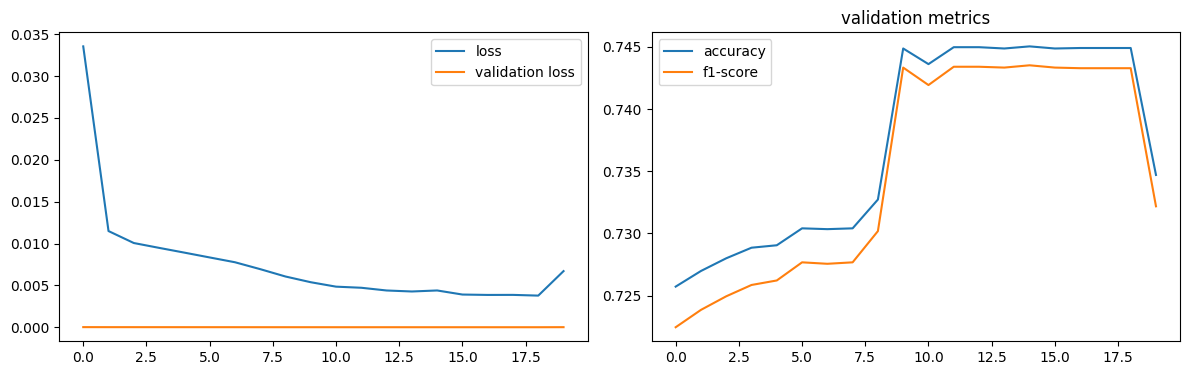

num of dropped: 1
Test: loss: 0.07799677550792694, avg metrics: (0.7449617385864258, 0.7437572717666626)
dropping feature: (5, 'Bytes Received')


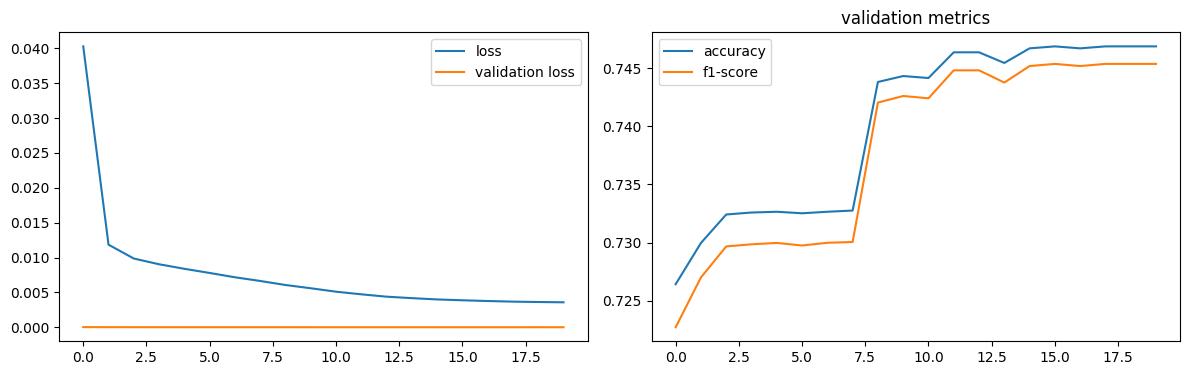

num of dropped: 2
Test: loss: 0.023451263085007668, avg metrics: (0.7446908354759216, 0.7432980895042419)
dropping feature: (7, 'pkts_sent')


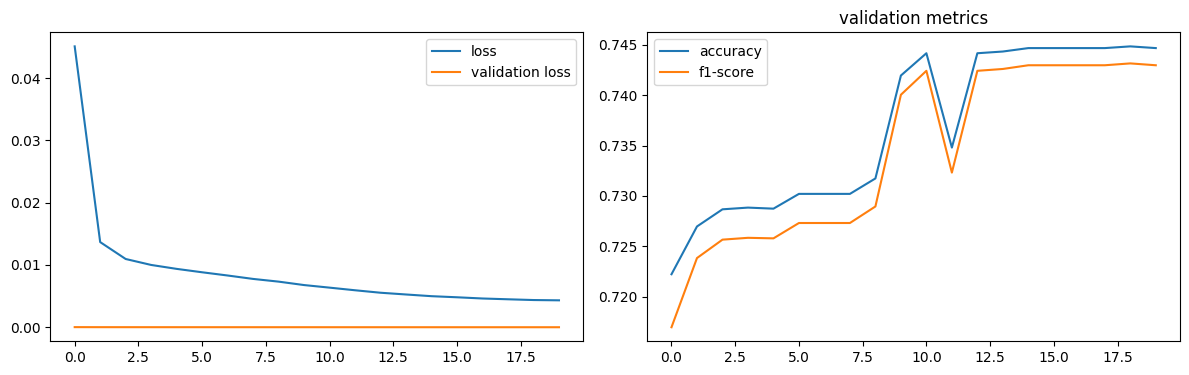

num of dropped: 3
Test: loss: 0.028215155005455017, avg metrics: (0.746881628036499, 0.7457832217216491)
dropping feature: (4, 'Bytes Sent')


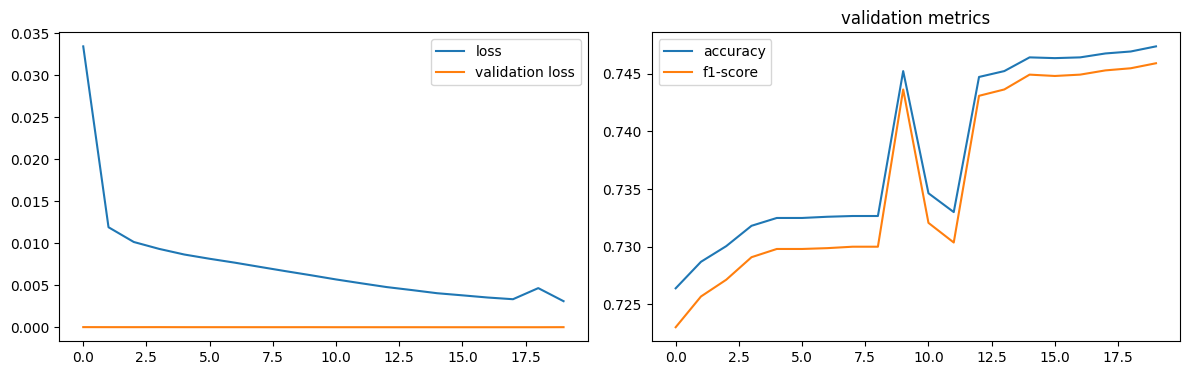

num of dropped: 4
Test: loss: 0.07306824624538422, avg metrics: (0.7448450446128845, 0.7436304330825806)
dropping feature: (1, 'NAT Source Port')


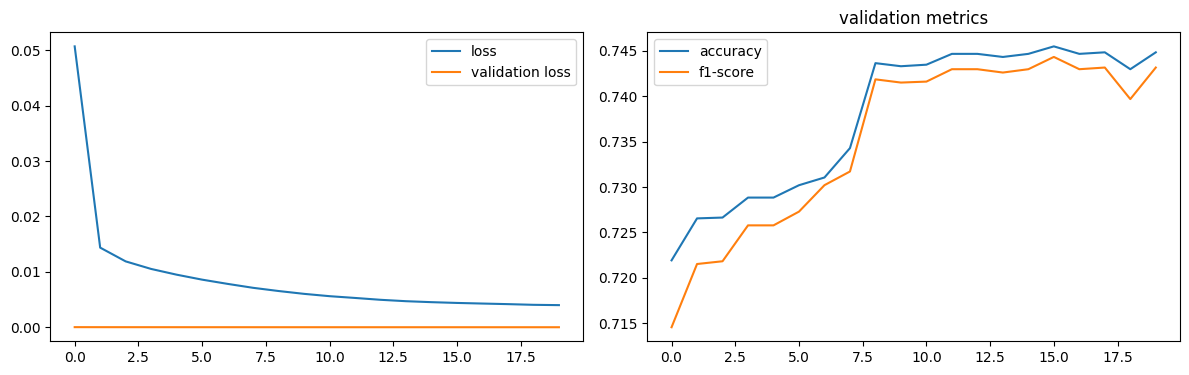

num of dropped: 5
Test: loss: 0.026406146585941315, avg metrics: (0.7434505581855774, 0.7413499116897583)
dropping feature: (2, 'Bytes')


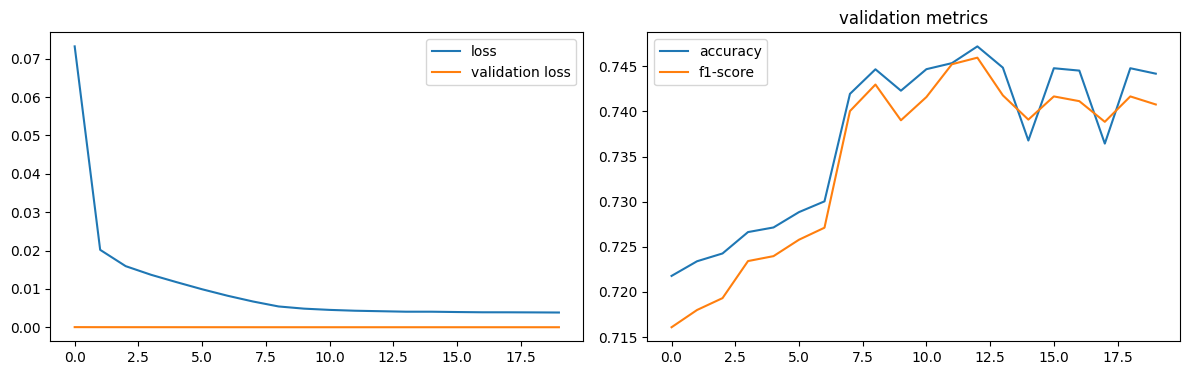

num of dropped: 6
Test: loss: 0.030556965619325638, avg metrics: (0.7465548276901245, 0.7448660731315613)
dropping feature: (4, 'pkts_received')


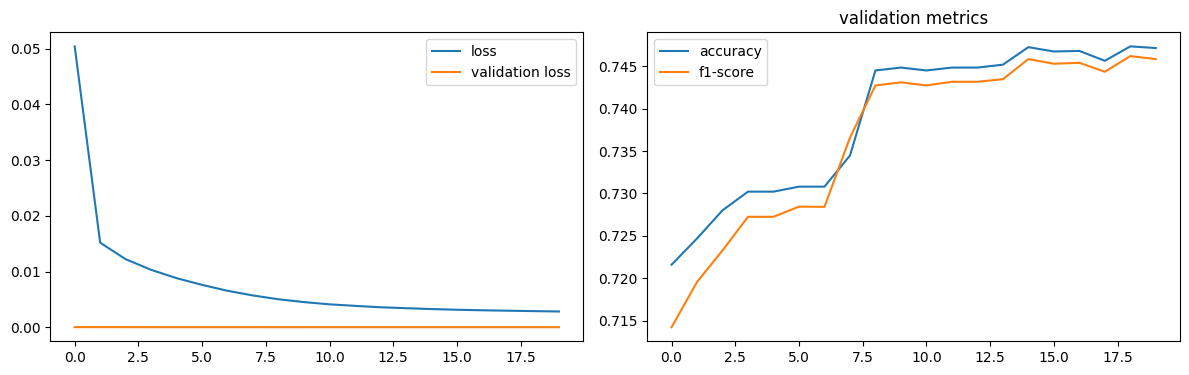

num of dropped: 7
Test: loss: 0.017948737367987633, avg metrics: (0.7449278593063354, 0.7435812830924988)
dropping feature: (2, 'Packets')


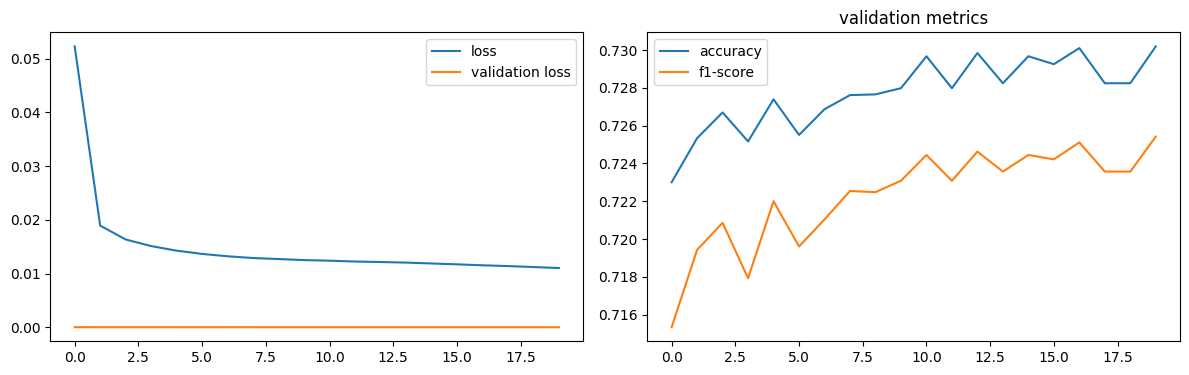

num of dropped: 8
Test: loss: 0.08484696596860886, avg metrics: (0.6358006834983826, 0.6197932451963425)
dropping feature: (1, 'NAT Destination Port')


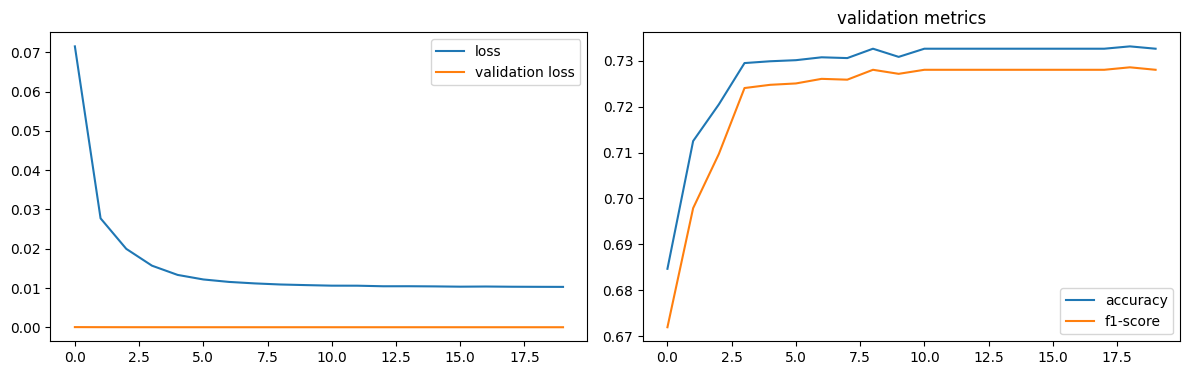

num of dropped: 9
Test: loss: 0.08177508413791656, avg metrics: (0.7243449687957764, 0.716595721244812)
dropping feature: (0, 'Destination Port')


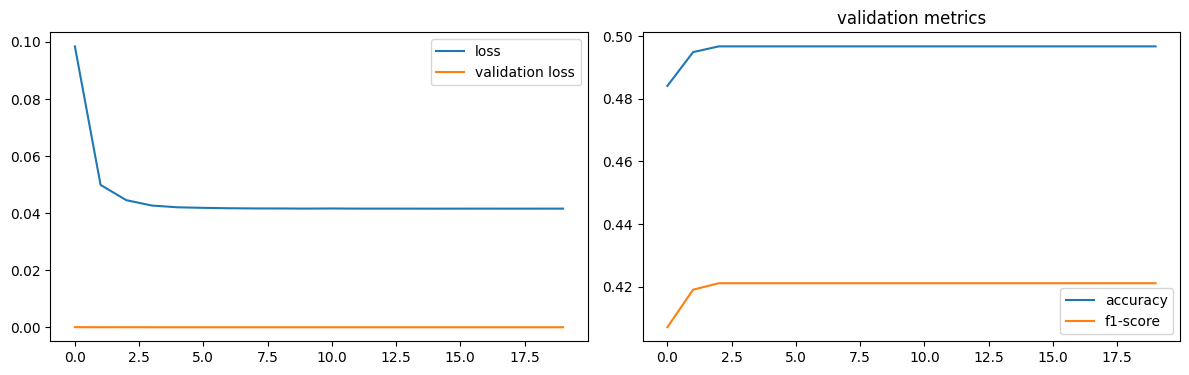

num of dropped: 10
Test: loss: 0.33200687170028687, avg metrics: (0.4972715377807617, 0.4203719198703766)


In [11]:
torch.manual_seed(2024)

datasets = firewall_datasets.copy()
headers = firewall_headers.copy()


def model_factory(size):
    return MLP(size)


test_metrics, dropped, models = prune(
    datasets, headers, analyze_dgsm,
    model_factory, optimizer_factory, criterion, score_outputs, 20,
    labels, "", None
)

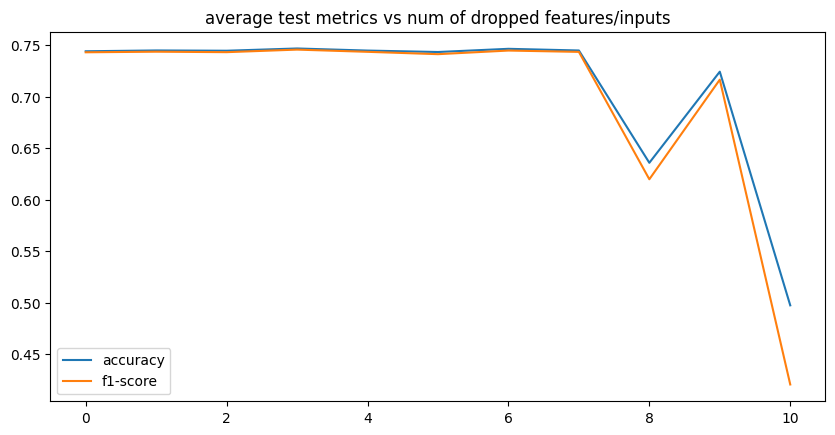

In [12]:
plot_dropping_metrics(test_metrics, labels)

In [13]:
num_drop_features = 7

save_models("firewall", "dgsm-layer1", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_features)
layer = models[num_drop_features].layer1

best_model.layer1 = layer

dgsm_datasets = reduced_datasets

features left [4]:  ['Destination Port', 'NAT Destination Port', 'Packets', 'Elapsed Time (sec)']


### 1st hidden layer

In [14]:
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

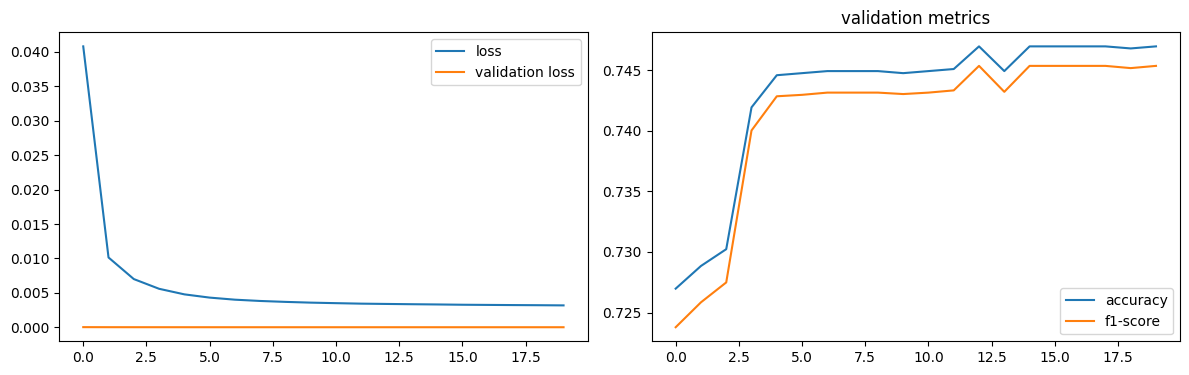

num of dropped: 0
Test: loss: 0.024640511721372604, avg metrics: (0.7392786264419555, 0.7375688195228577)
dropping feature: (0, 'neuron0')


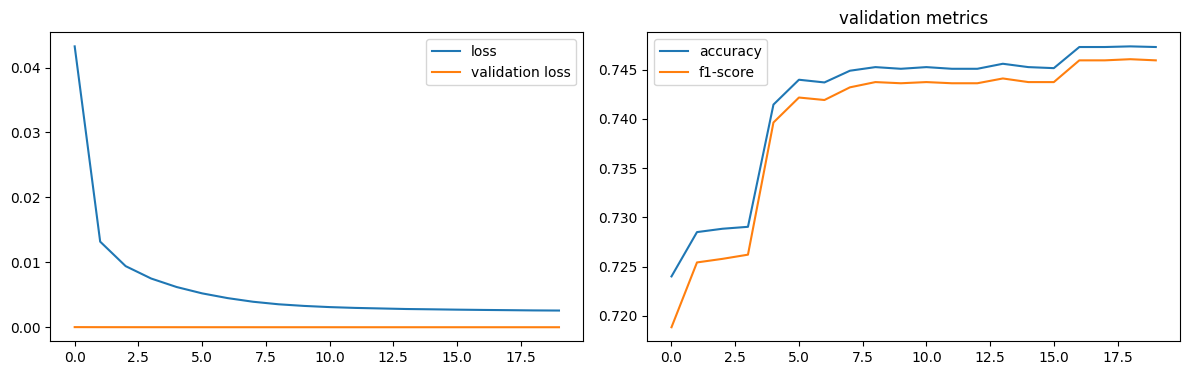

num of dropped: 1
Test: loss: 0.016384270042181015, avg metrics: (0.7413694024085998, 0.7395021677017212)
dropping feature: (0, 'neuron1')


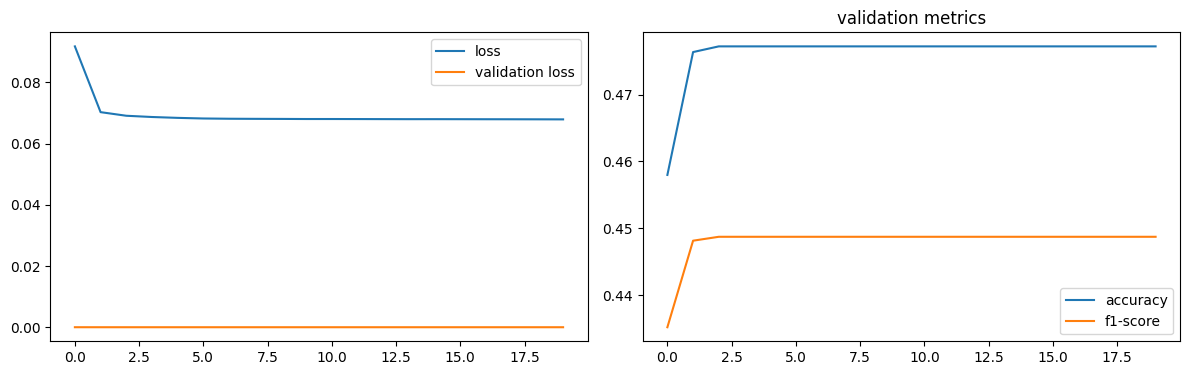

num of dropped: 2
Test: loss: 0.548620879650116, avg metrics: (0.6885322093963623, 0.6810818433761596)
dropping feature: (0, 'neuron2')


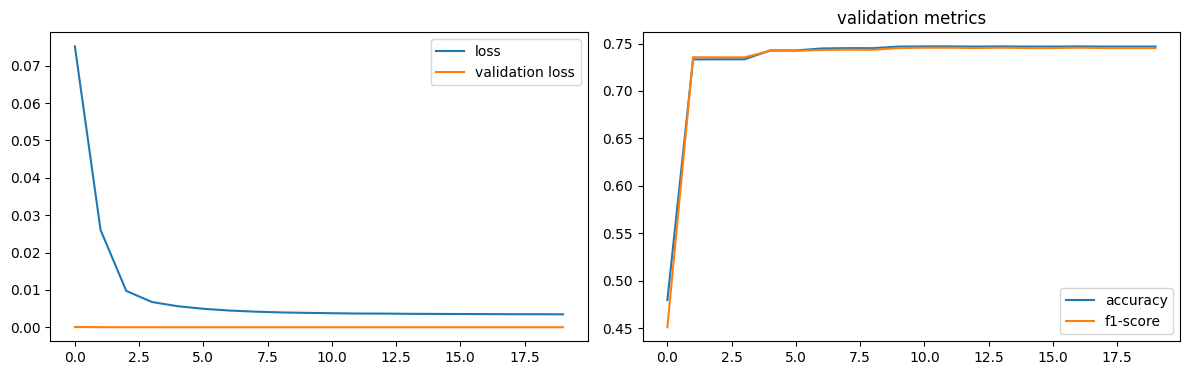

num of dropped: 3
Test: loss: 0.02450559288263321, avg metrics: (0.744670295715332, 0.7431535005569458)


In [15]:
torch.manual_seed(2024)

headers = [f"neuron{i}" for i in range(4)]


def model_factory(size):
    model = MLP(1, (size, 4))
    model.layer1 = nn.Identity()
    return model


test_metrics, dropped, models = prune(
    datasets, headers, analyze_dgsm,
    model_factory, optimizer_factory, criterion, score_outputs, 20,
    labels, "", None
)

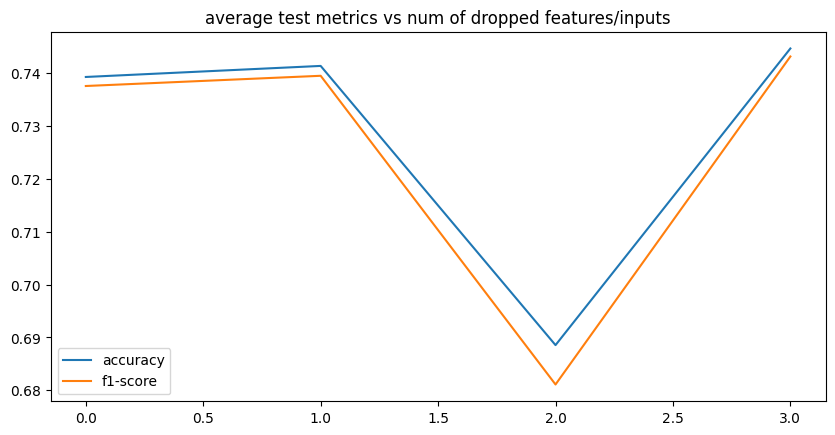

In [16]:
plot_dropping_metrics(test_metrics, labels)

In [17]:
num_drop_neurons = 1

save_models("firewall", "dgsm-layer2", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_neurons)
layer = models[num_drop_neurons].layer2

best_model.layer2 = layer
best_model.layer1[0] = reduce_linear(best_model.layer1[0], dropped, num_drop_neurons)

features left [3]:  ['neuron1', 'neuron2', 'neuron3']


### 2nd hidden layer

In [18]:
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

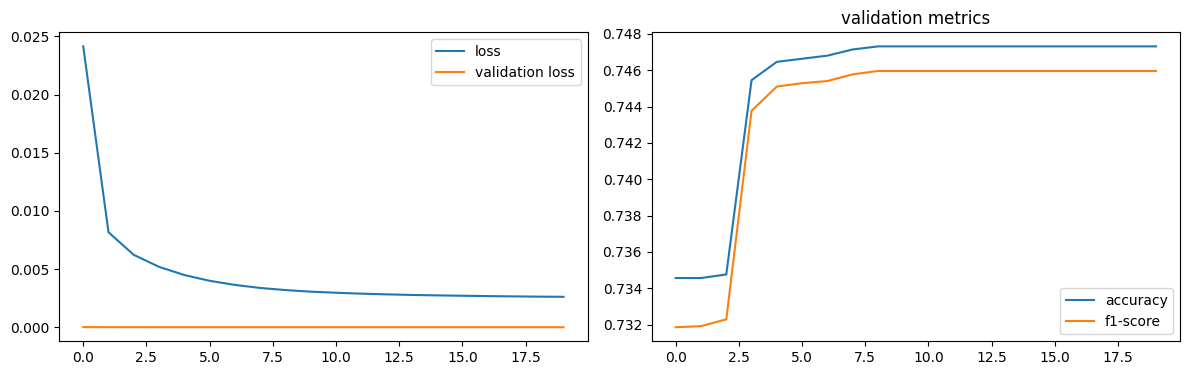

num of dropped: 0
Test: loss: 0.01681569777429104, avg metrics: (0.747620701789856, 0.74653559923172)
dropping feature: (0, 'neuron0')


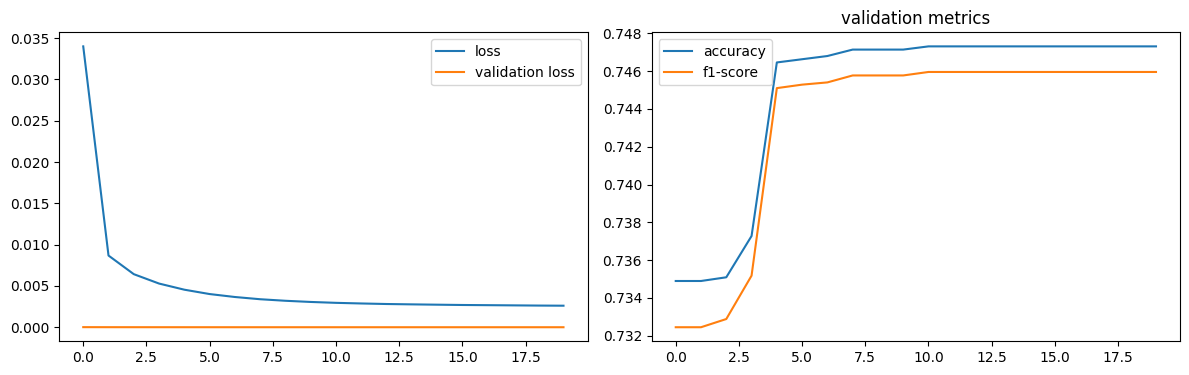

num of dropped: 1
Test: loss: 0.016831902787089348, avg metrics: (0.747620701789856, 0.74653559923172)
dropping feature: (2, 'neuron3')


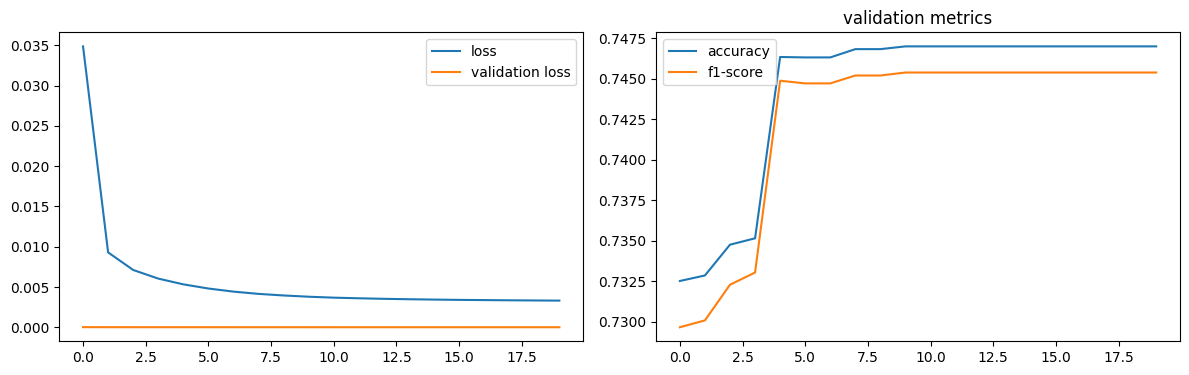

num of dropped: 2
Test: loss: 0.023995796218514442, avg metrics: (0.7472102403640747, 0.7458248853683471)
dropping feature: (0, 'neuron1')


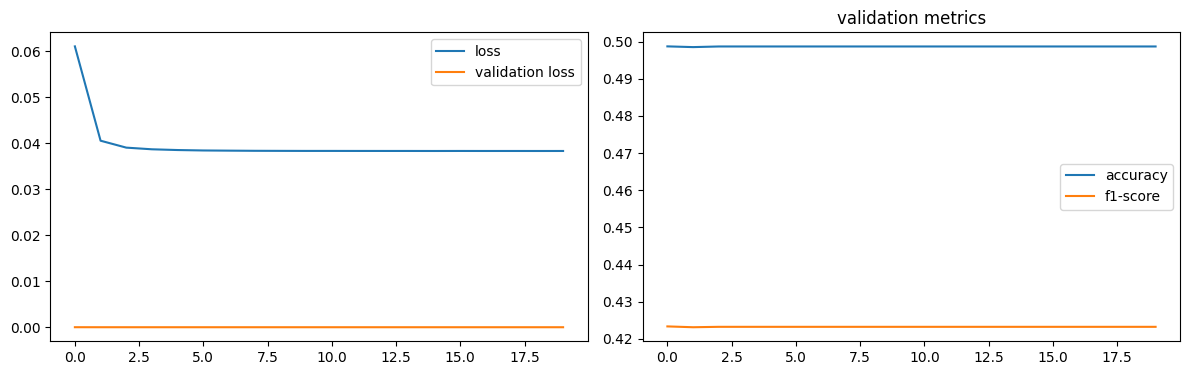

num of dropped: 3
Test: loss: 0.30507540702819824, avg metrics: (0.49862468242645264, 0.4218658208847046)


In [19]:
torch.manual_seed(2024)

headers = [f"neuron{i}" for i in range(4)]


def model_factory(size):
    model = MLP(1, (1, size))
    model.layer1 = nn.Identity()
    model.layer2 = nn.Identity()
    return model


test_metrics, dropped, models = prune(
    datasets, headers, analyze_dgsm,
    model_factory, optimizer_factory, criterion, score_outputs, 20,
    labels, "", None
)

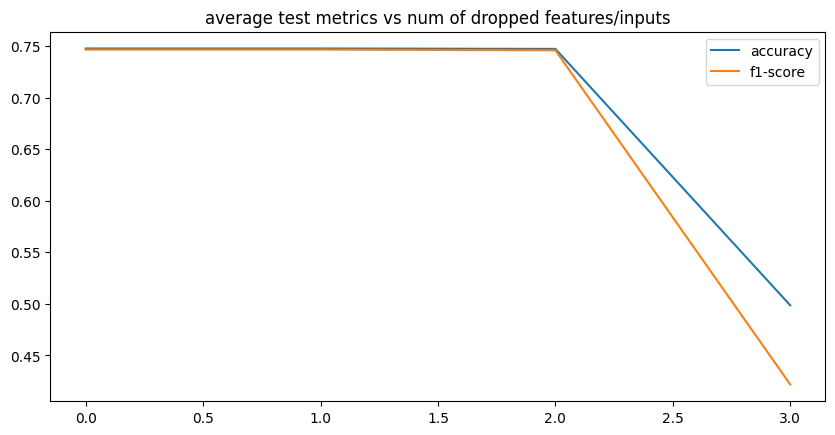

In [20]:
plot_dropping_metrics(test_metrics, labels)

In [21]:
num_drop_neurons = 2

save_models("firewall", "dgsm-layer3", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_neurons)
layer = models[num_drop_neurons].out

best_model.out = layer
best_model.layer2[0] = reduce_linear(best_model.layer2[0], dropped, num_drop_neurons)

features left [2]:  ['neuron1', 'neuron2']


### pruned

In [22]:
best_model

MLP(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=3, out_features=2, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=2, out_features=4, bias=True)
)

In [23]:
with torch.no_grad():
    inputs, targets = dgsm_datasets["test"][:]
    outputs = best_model(inputs)

    test_metrics = score_outputs(outputs, targets)

print(f"test {labels}: {test_metrics}")

test ('accuracy', 'f1-score'): (0.7472214698791504, 0.7458368539810181)


test: ('accuracy', 'f1-score'): (0.7472214698791504, 0.7458368539810181)


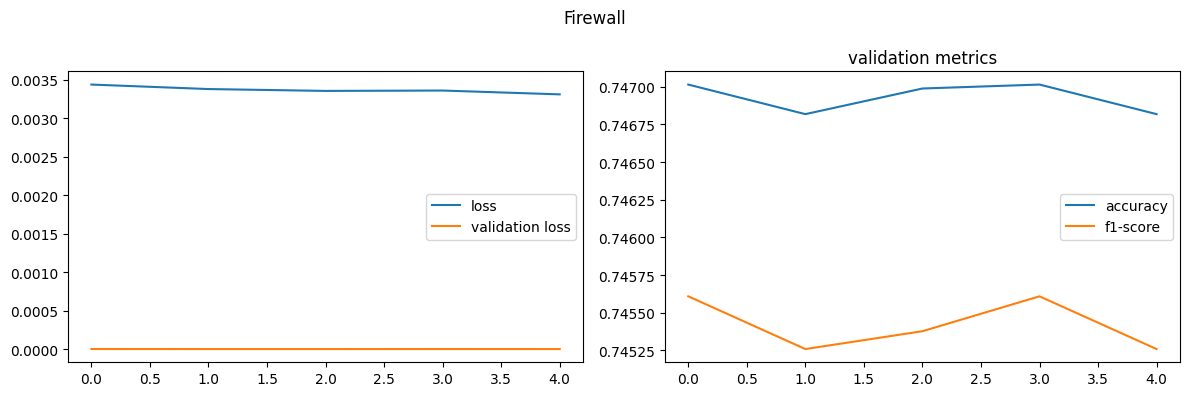

In [24]:
optimizer = optimizer_factory(best_model)
metrics = model_train(dgsm_datasets, best_model, optimizer, criterion, score_outputs, 5)

with torch.no_grad():
    inputs, targets = dgsm_datasets["test"][:]
    outputs = best_model(inputs)

    test_metrics = score_outputs(outputs, targets)

print(f"test: {labels}: {test_metrics}")
plot_metrics('Firewall', metrics, labels)

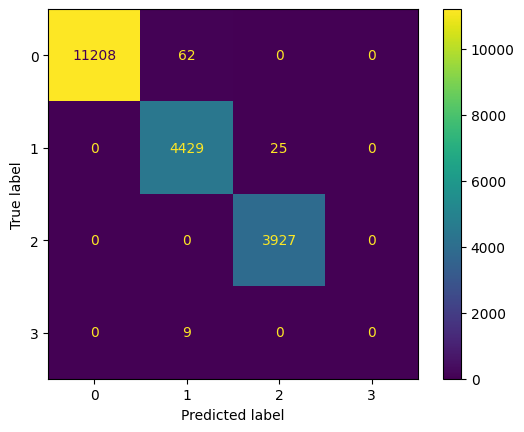

In [25]:
ConfusionMatrixDisplay.from_predictions(targets, outputs.argmax(dim=1))
plt.show()

In [26]:
save_models("firewall", "dgsm-prunned", [best_model], None)

## FAST

In [27]:
best_model = MLP()

### input layer

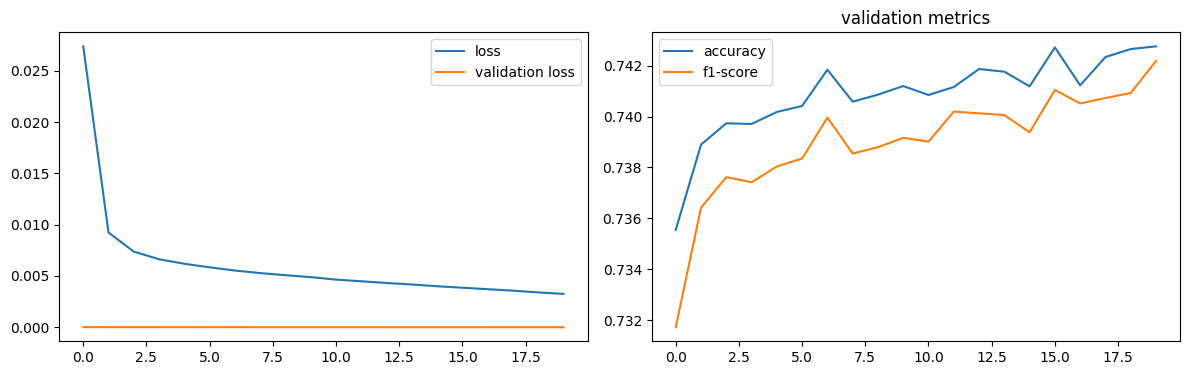

num of dropped: 0
Test: loss: 0.019204678013920784, avg metrics: (0.7441701650619507, 0.7431782841682434)
dropping feature: (0, 'Source Port')


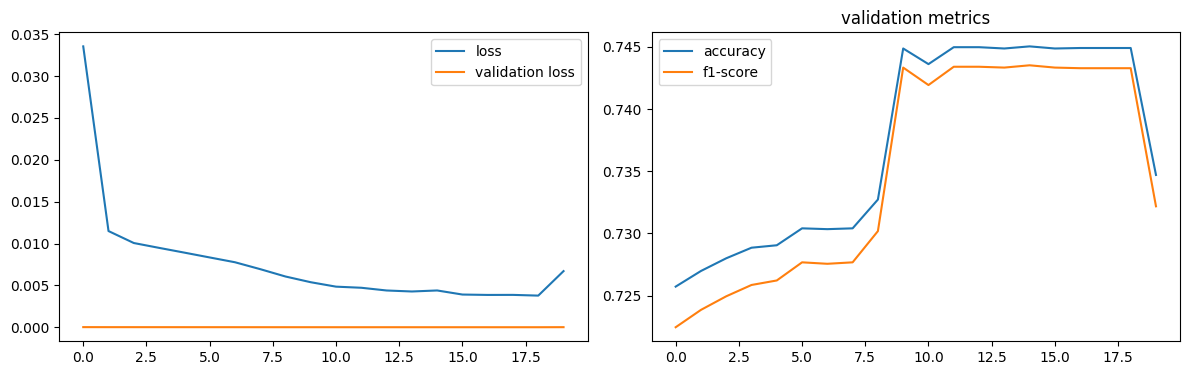

num of dropped: 1
Test: loss: 0.07799677550792694, avg metrics: (0.7449617385864258, 0.7437572717666626)
dropping feature: (5, 'Bytes Received')


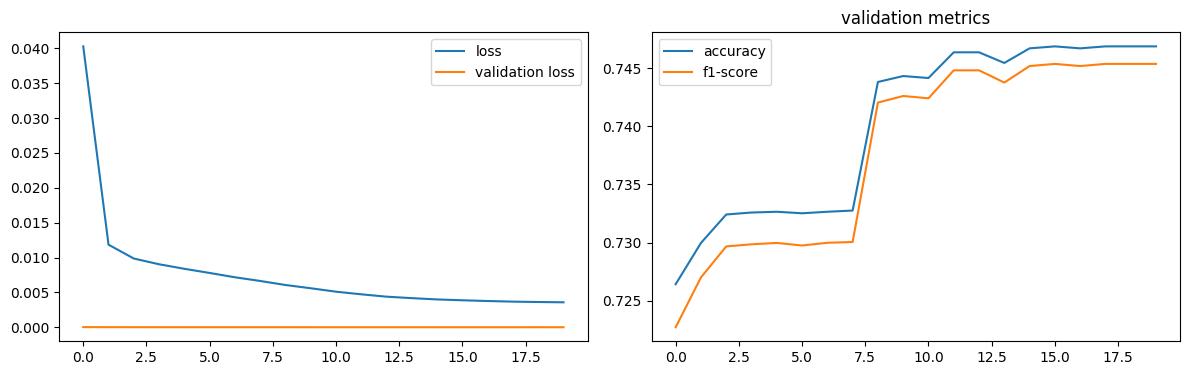

num of dropped: 2
Test: loss: 0.023451263085007668, avg metrics: (0.7446908354759216, 0.7432980895042419)
dropping feature: (1, 'NAT Source Port')


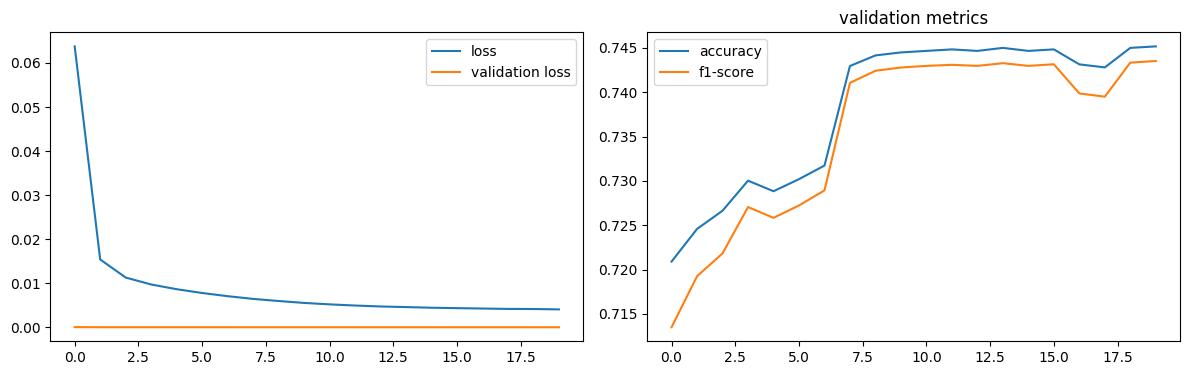

num of dropped: 3
Test: loss: 0.029093509539961815, avg metrics: (0.7469817757606506, 0.7455560803413391)
dropping feature: (3, 'Bytes Sent')


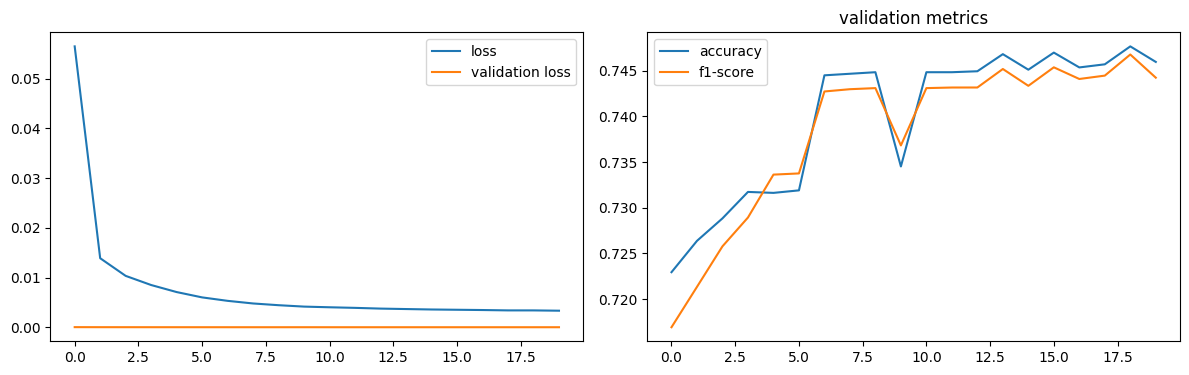

num of dropped: 4
Test: loss: 0.03518849238753319, avg metrics: (0.7432935237884521, 0.7414587736129761)
dropping feature: (2, 'Bytes')


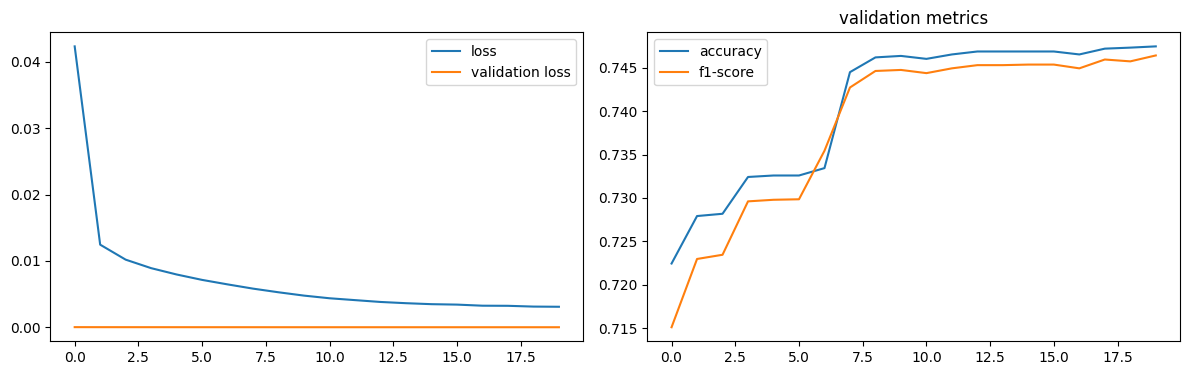

num of dropped: 5
Test: loss: 0.023921774700284004, avg metrics: (0.7432156682014466, 0.7409320592880249)
dropping feature: (5, 'pkts_received')


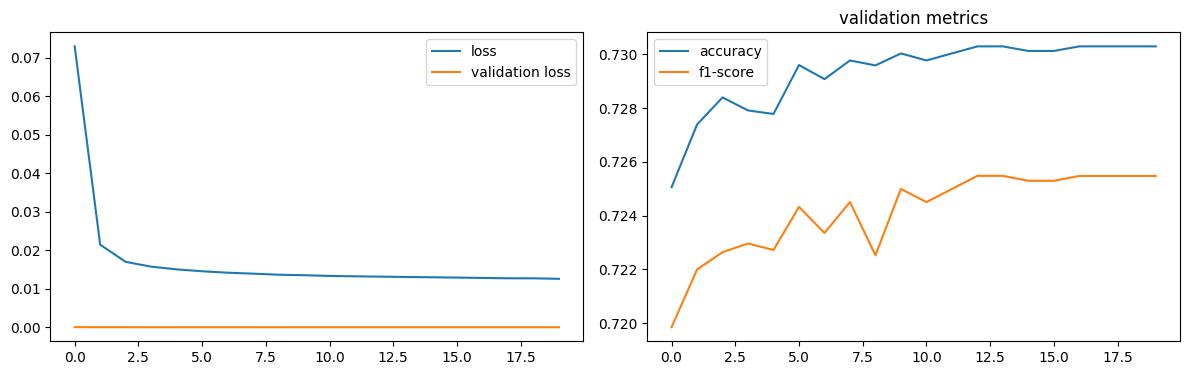

num of dropped: 6
Test: loss: 0.09603755921125412, avg metrics: (0.7412222623825073, 0.7391496300697327)
dropping feature: (1, 'NAT Destination Port')


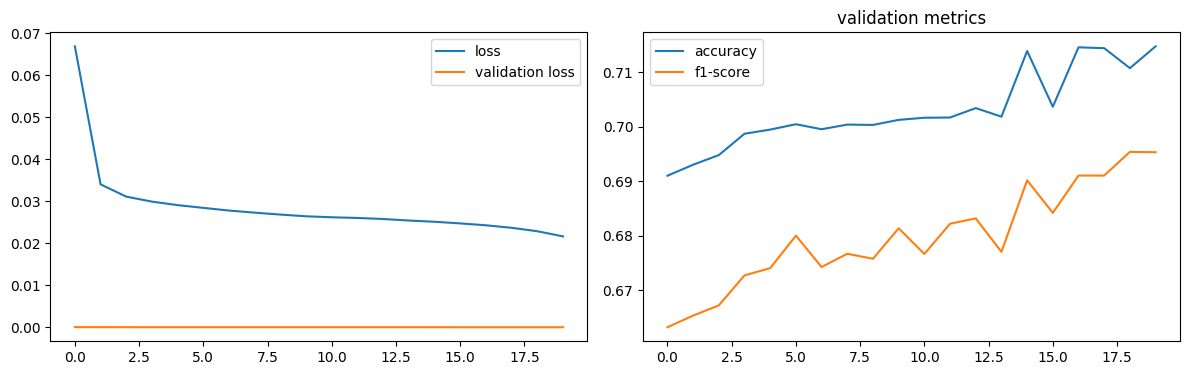

num of dropped: 7
Test: loss: 0.16969440877437592, avg metrics: (0.7318051218986511, 0.725701916217804)
dropping feature: (1, 'Packets')


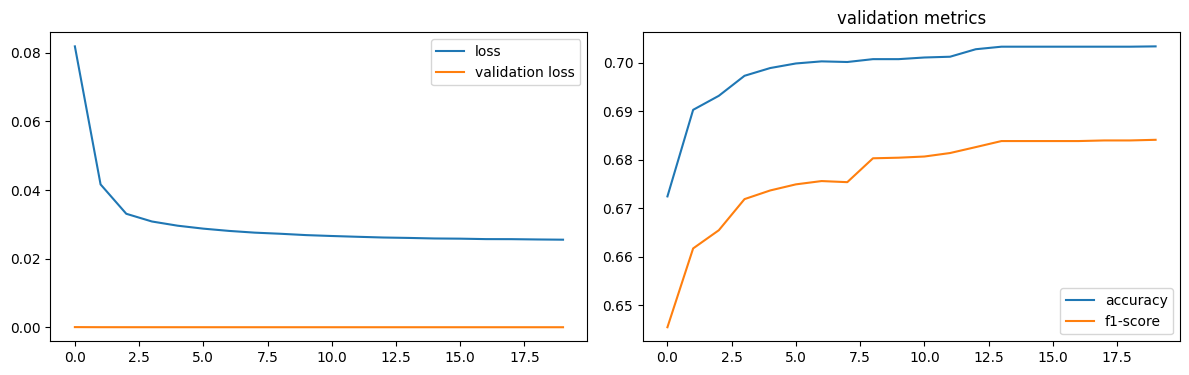

num of dropped: 8
Test: loss: 0.19865074753761292, avg metrics: (0.6329141974449157, 0.6140131562948227)
dropping feature: (0, 'Destination Port')


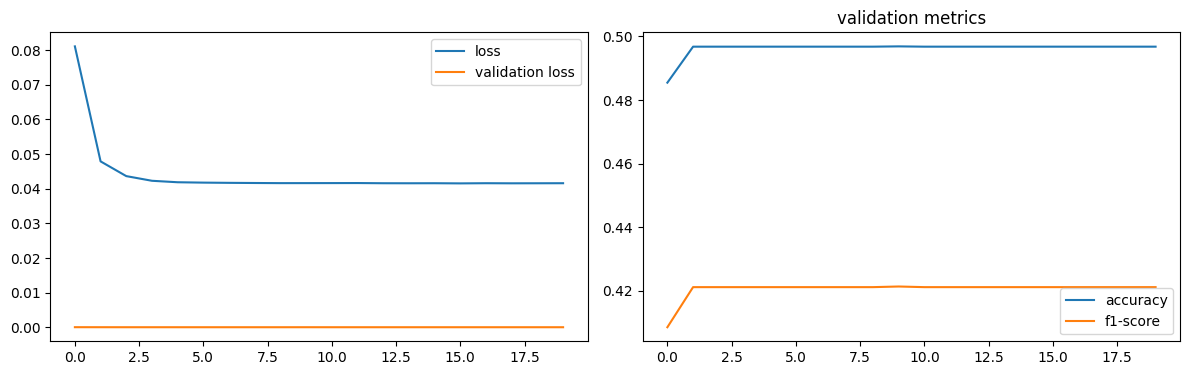

num of dropped: 9
Test: loss: 0.33062833547592163, avg metrics: (0.4972715377807617, 0.4203719198703766)
dropping feature: (1, 'pkts_sent')


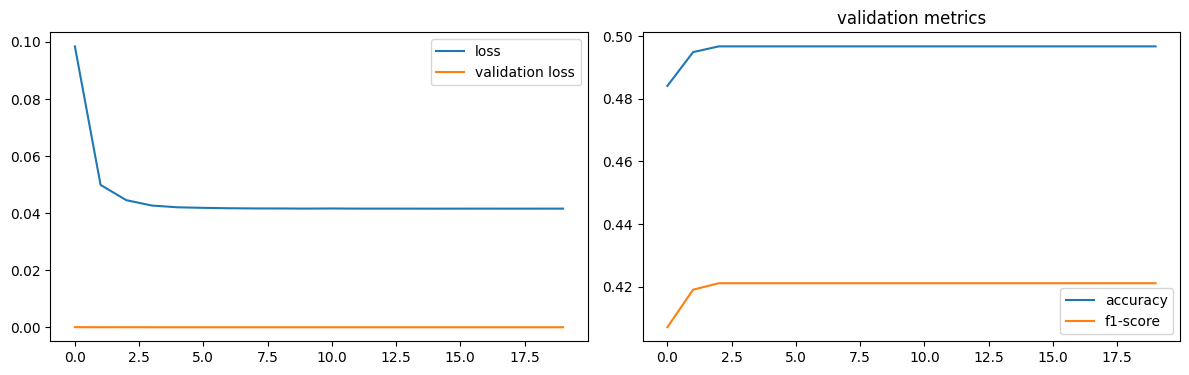

num of dropped: 10
Test: loss: 0.33200687170028687, avg metrics: (0.4972715377807617, 0.4203719198703766)


In [28]:
torch.manual_seed(2024)

datasets = firewall_datasets.copy()
headers = firewall_headers.copy()


def model_factory(size):
    return MLP(size)


test_metrics, dropped, models = prune(
    datasets, headers, analyze_fast,
    model_factory, optimizer_factory, criterion, score_outputs, 20,
    labels, "", None
)

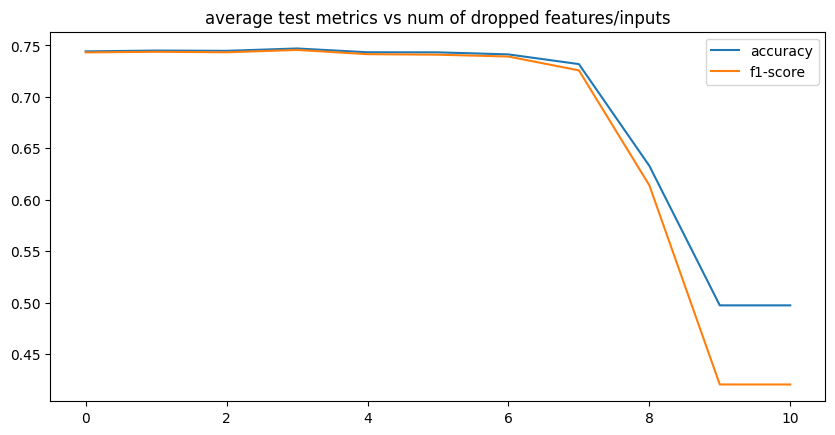

In [29]:
plot_dropping_metrics(test_metrics, labels)

In [30]:
num_drop_features = 3

save_models("firewall", "fast-layer1", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_features)
layer = models[num_drop_features].layer1

best_model.layer1 = layer

fast_dataset = reduced_datasets

features left [8]:  ['Destination Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']


### 1st hidden layer

In [31]:
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

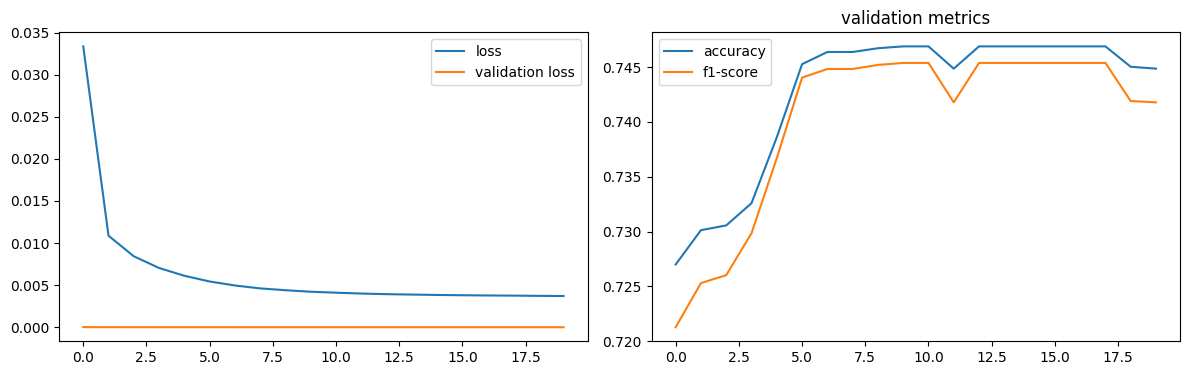

num of dropped: 0
Test: loss: 0.026700465008616447, avg metrics: (0.7435201287269593, 0.7411775946617126)
dropping feature: (3, 'neuron3')


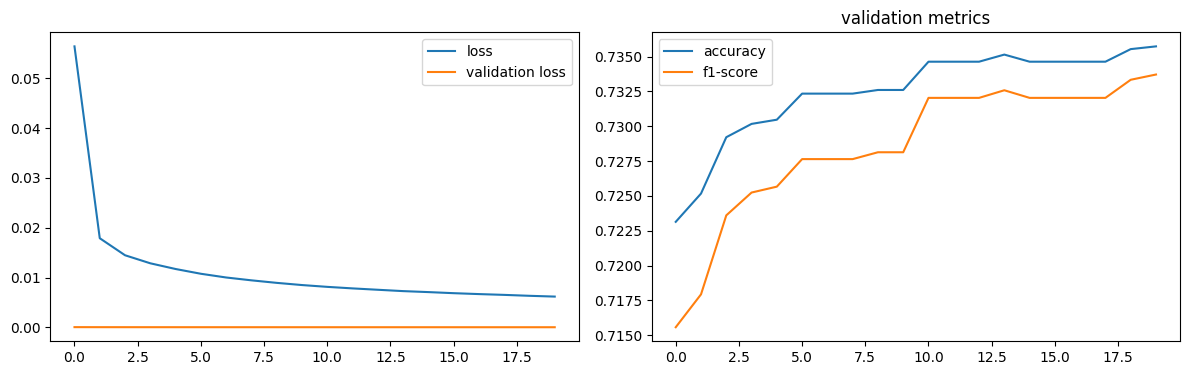

num of dropped: 1
Test: loss: 0.04719388484954834, avg metrics: (0.7436084628105164, 0.741650128364563)
dropping feature: (1, 'neuron1')


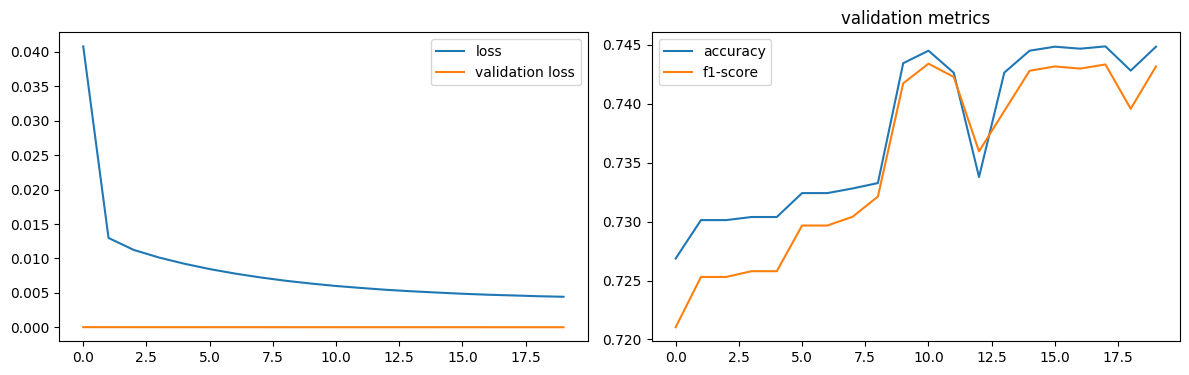

num of dropped: 2
Test: loss: 0.03269782289862633, avg metrics: (0.738384997844696, 0.7370898127555847)
dropping feature: (0, 'neuron0')


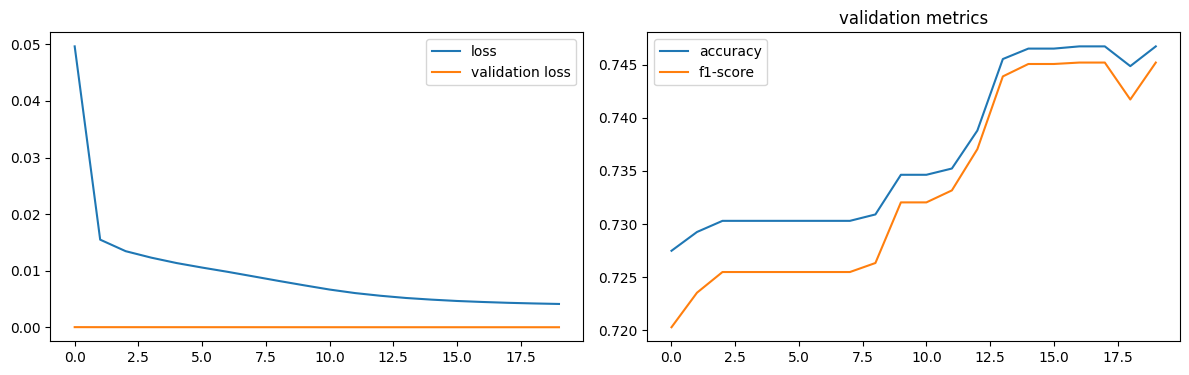

num of dropped: 3
Test: loss: 0.03018292412161827, avg metrics: (0.737320625782013, 0.7344037175178528)


In [32]:
torch.manual_seed(2024)

headers = [f"neuron{i}" for i in range(4)]

def model_factory(size):
    model = MLP(1, (size, 4))
    model.layer1 = nn.Identity()
    return model


test_metrics, dropped, models = prune(
    datasets, headers, analyze_fast,
    model_factory, optimizer_factory, criterion, score_outputs, 20,
    labels, "", None
)

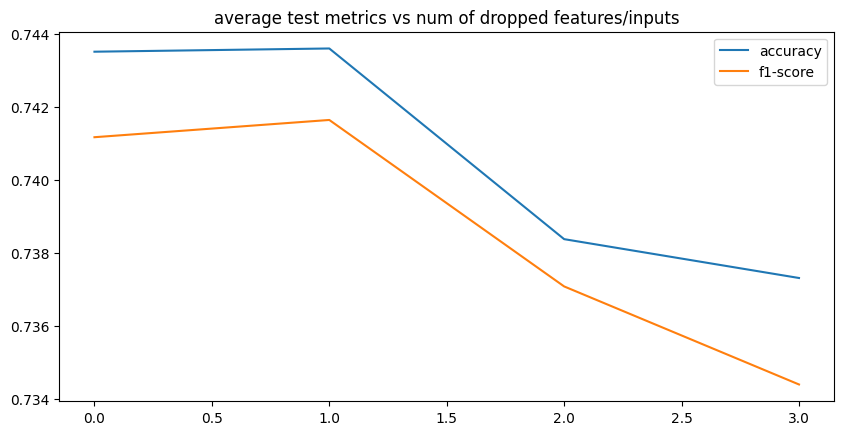

In [33]:
plot_dropping_metrics(test_metrics, labels)

In [34]:
num_drop_neurons = 1

save_models("firewall", "fast-layer2", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_neurons)
layer = models[num_drop_neurons].layer2

best_model.layer2 = layer
best_model.layer1[0] = reduce_linear(best_model.layer1[0], dropped, num_drop_neurons)

features left [3]:  ['neuron0', 'neuron1', 'neuron2']


### 2nd hidden layer

In [35]:
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

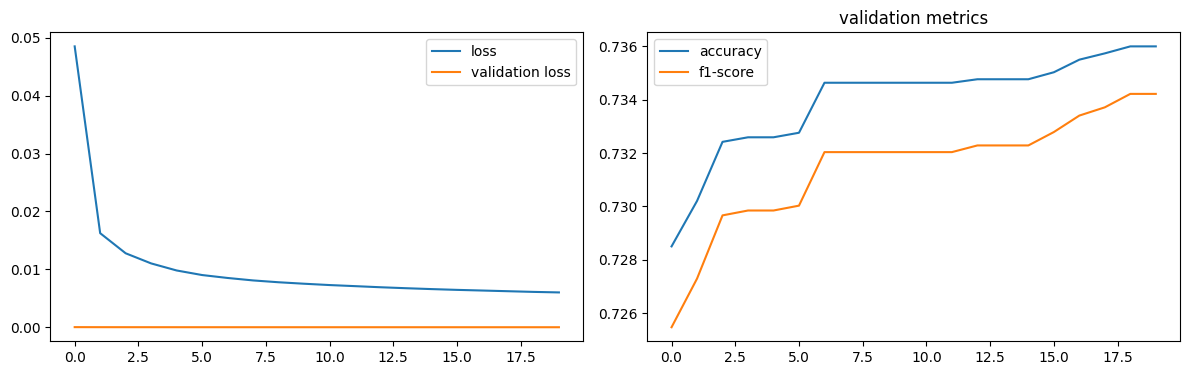

num of dropped: 0
Test: loss: 0.046505436301231384, avg metrics: (0.7350406527519227, 0.7333367943763733)
dropping feature: (2, 'neuron2')


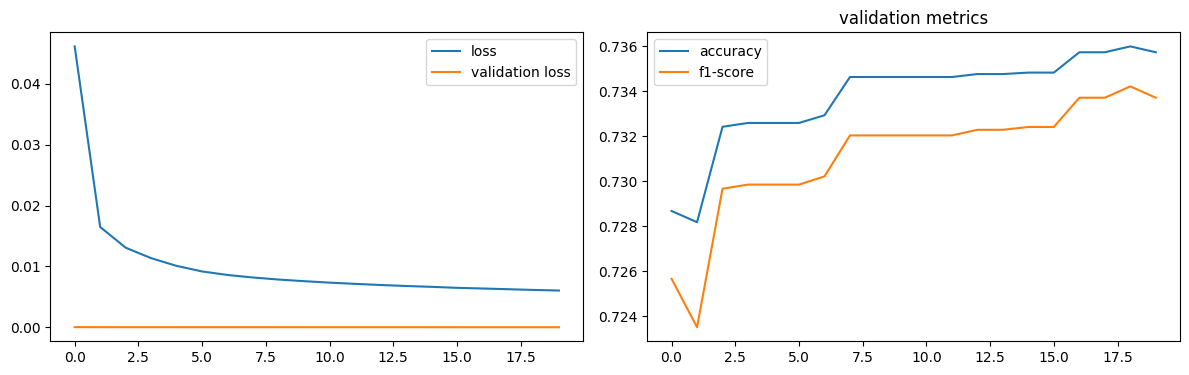

num of dropped: 1
Test: loss: 0.0468333475291729, avg metrics: (0.7350894451141358, 0.7334607839584351)
dropping feature: (0, 'neuron0')


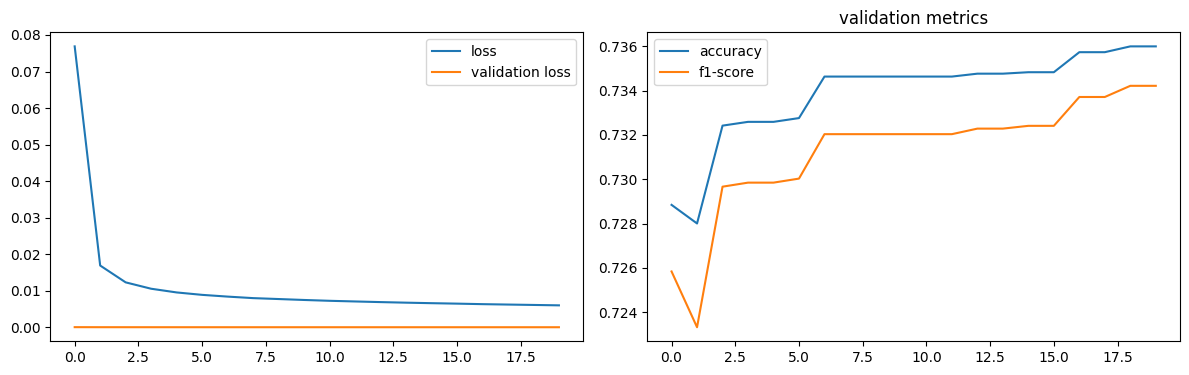

num of dropped: 2
Test: loss: 0.046547308564186096, avg metrics: (0.7350406408309936, 0.7335345864295959)
dropping feature: (0, 'neuron1')


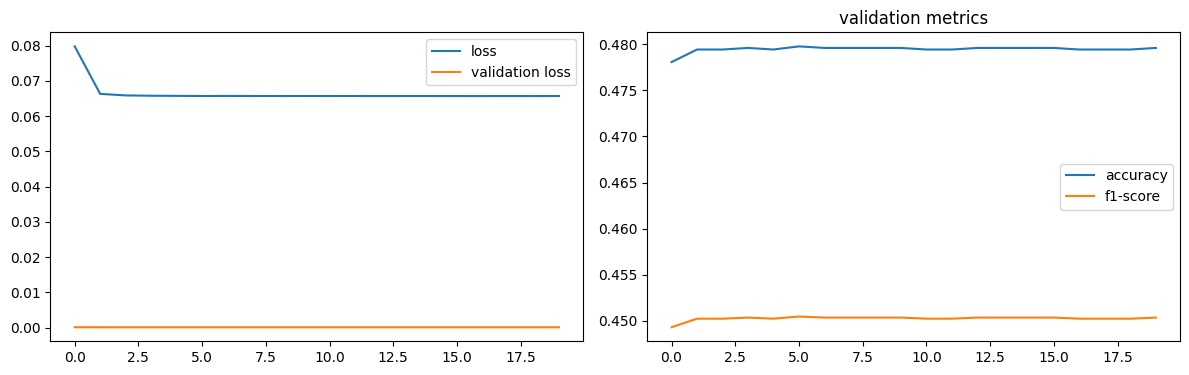

num of dropped: 3
Test: loss: 0.531441867351532, avg metrics: (0.4811472535133362, 0.4496198296546936)


In [36]:
torch.manual_seed(2024)

headers = [f"neuron{i}" for i in range(4)]


def model_factory(size):
    model = MLP(1, (1, size))
    model.layer1 = nn.Identity()
    model.layer2 = nn.Identity()
    return model


test_metrics, dropped, models = prune(
    datasets, headers, analyze_dgsm,
    model_factory, optimizer_factory, criterion, score_outputs, 20,
    labels, "", None
)

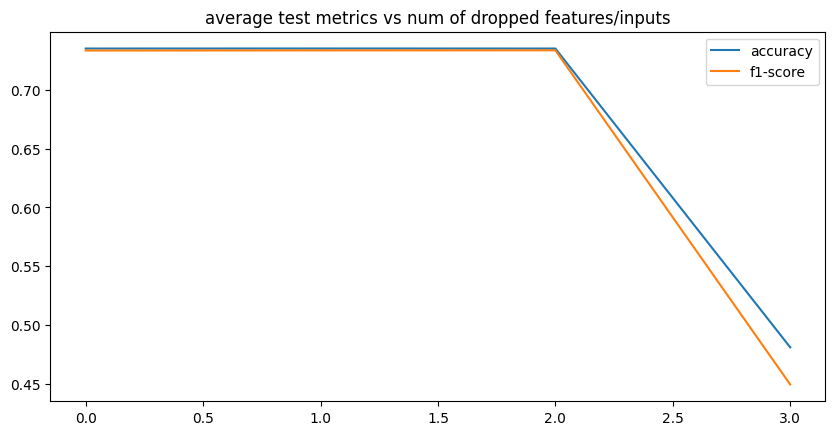

In [37]:
plot_dropping_metrics(test_metrics, labels)

In [38]:
num_drop_neurons = 2

save_models("firewall", "fast-layer3", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_neurons)
layer = models[num_drop_neurons].out

best_model.out = layer
best_model.layer2[0] = reduce_linear(best_model.layer2[0], dropped, num_drop_neurons)

features left [2]:  ['neuron1', 'neuron3']


### pruned

In [39]:
best_model

MLP(
  (layer1): Sequential(
    (0): Linear(in_features=8, out_features=3, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=3, out_features=2, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=2, out_features=4, bias=True)
)

In [40]:
with torch.no_grad():
    inputs, targets = fast_dataset["test"][:]
    outputs = best_model(inputs)

    test_metrics = score_outputs(outputs, targets)

print(f"test {labels}: {test_metrics}")

test ('accuracy', 'f1-score'): (0.7352446913719177, 0.7338491082191467)


test: ('accuracy', 'f1-score'): (0.7346639037132263, 0.7328720688819885)


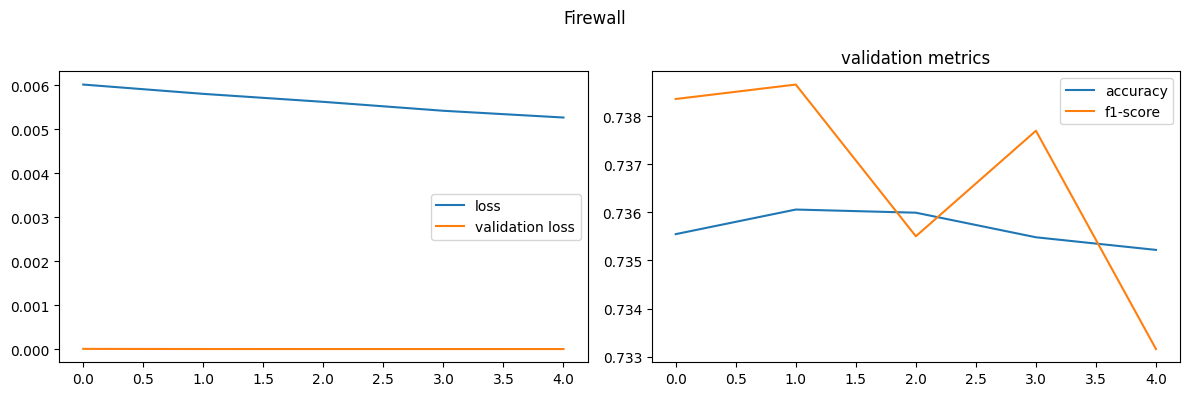

In [41]:
optimizer = optimizer_factory(best_model)
metrics = model_train(fast_dataset, best_model, optimizer, criterion, score_outputs, 5)

with torch.no_grad():
    inputs, targets = fast_dataset["test"][:]
    outputs = best_model(inputs)

    test_metrics = score_outputs(outputs, targets)

print(f"test: {labels}: {test_metrics}")
plot_metrics('Firewall', metrics, labels)

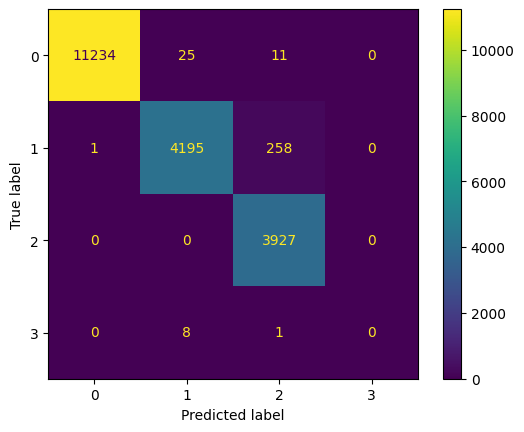

In [42]:
ConfusionMatrixDisplay.from_predictions(targets, outputs.argmax(dim=1))
plt.show()

In [43]:
save_models("firewall", "fast-prunned", [best_model], None)